### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Assignment 1

**Student Name:**    `PLEASE ENTER YOUR NAME HERE`

**Student ID:**     `PLEASE ENTER YOUR ID HERE`

This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a writren report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. Load images and compute correspondences


In [80]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

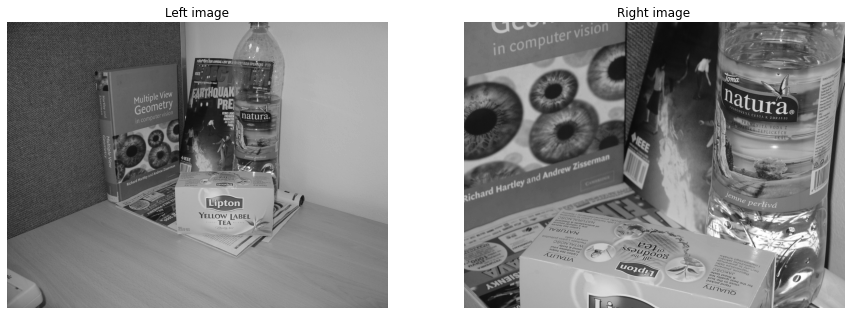

In [81]:
# Code from workshop 8
# Read in images from a filepath as graycsale.
imgA = cv2.imread("kusvod2/zoomA.png", cv2.IMREAD_GRAYSCALE)
imgB = cv2.imread("kusvod2/zoomB.png", cv2.IMREAD_GRAYSCALE)

# Display the images
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(imgA, cmap='gray')  
plt.title('Left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(imgB, cmap='gray')  
plt.title('Right image')
plt.axis('off')

plt.show() 

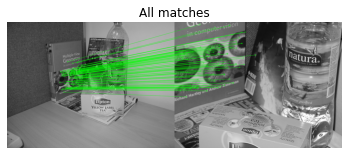

In [82]:
# Code from workshop 7 and 8
# Initiate SIFT detector
sift = cv2.SIFT_create()

# Compute SIFT keypoints and descriptors
kp1, des1 = sift.detectAndCompute(imgA, None)
kp2, des2 = sift.detectAndCompute(imgB, None)

# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8 * n.distance:
        good.append(m)

# Estimate homography between two images
ptsA = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
ptsB = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
H, status = cv2.findHomography( ptsA, 
                                ptsB, 
                                cv2.RANSAC, 
                                ransacReprojThreshold = 5, 
                                maxIters = 500)

matchesMask = status.ravel().tolist()

# Draw our inliers
draw_params = dict(matchColor = (0,255,0), # draw in a specific colour
                   singlePointColor = (255,0,0), # draw in a specific colour
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

success_matches = cv2.drawMatches(imgA,kp1,imgB,kp2,good,None,**draw_params)

# Plotting results
plt.imshow(success_matches)
plt.title('All matches')
plt.axis('off')

plt.show()

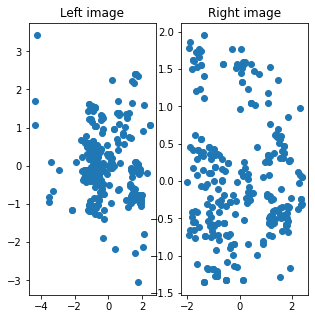

In [129]:
# Shift and scale pixel coordinates
def shift_scale(pts):
    pts_clean = [x[0] for x in pts]

    x_centroid = sum([x[0] for x in pts_clean])/len(pts_clean)
    y_centroid = sum([x[1] for x in pts_clean])/len(pts_clean)

    pts_shifted = \
        [[x[0] - x_centroid, x[1] - y_centroid] for x in pts_clean]

    sum_distance = sum([np.sqrt(x[0]**2 + x[1]**2) for x in pts_shifted])
    avg_distance = sum_distance/len(pts_shifted)
    scale_factor = np.sqrt(2) / avg_distance

    pts_shifted_scaled = \
        [[x[0] * scale_factor, x[1] * scale_factor] for x in pts_shifted]

    return pts_shifted_scaled, x_centroid, y_centroid, scale_factor

ptsA_ss, ptsA_x, ptsA_y, ptsA_s = shift_scale(ptsA)
ptsB_ss, ptsB_x, ptsB_y, ptsB_s = shift_scale(ptsB)

# Display the images
plt.subplots(figsize=(5, 5)) 

plt.subplot(1,2,1)
plt.scatter([x[0] for x in ptsA_ss], [x[1] for x in ptsA_ss])
plt.title('Left image')

plt.subplot(1,2,2)
plt.scatter([x[0] for x in ptsB_ss], [x[1] for x in ptsB_ss])
plt.title('Right image')

plt.show() 

In [131]:
# Construct design matrix
matrix = []
for i in range(len(ptsA_ss)):
    p1 = ptsA_ss[i][0]
    p2 = ptsA_ss[i][1]
    q1 = ptsB_ss[i][0]
    q2 = ptsB_ss[i][1]
    row = [p1*q1, p2*q1, q1, p1*q2, p2*q2, q2, p1, p2, 1]
    matrix.append(row)

In [9]:
# TODO: replace
F, mask = cv2.findFundamentalMat(ptsL,ptsR,cv2.FM_LMEDS)

# Select only inlier points
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# print the fundamental matrix
print(F)

[[-1.12226343e-07 -6.23879821e-08  5.85880174e-04]
 [ 4.02991379e-08  2.03440001e-07  8.05792842e-04]
 [-1.55718078e-03 -2.13577912e-03  1.00000000e+00]]


In [10]:
# Code from workshop 8
# create a function to draw epilines over the images
# Epilines corresponding to the points in first image is drawn on second image
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1,img2

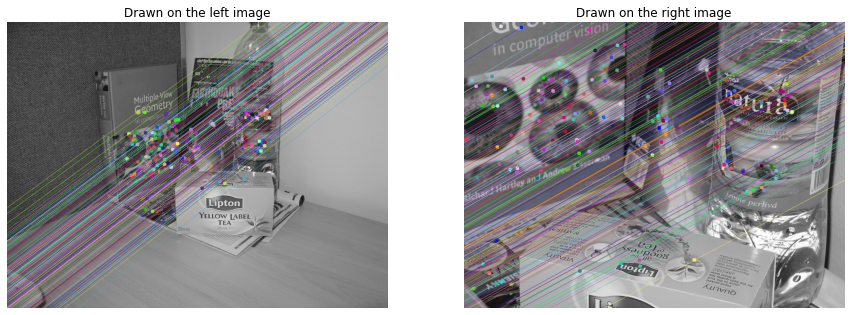

In [11]:
# Code from workshop 8
# Find epilines corresponding to points in right image 
# and draw its lines on left image
linesL = cv2.computeCorrespondEpilines(ptsR.reshape(-1,1,2), 2, F)
linesL = linesL.reshape(-1,3)
img5, img6 = drawlines(imgA, imgB, linesL, ptsL, ptsR)

# Find epilines corresponding to points in left image 
# and draw its lines on right image
linesR = cv2.computeCorrespondEpilines(ptsL.reshape(-1,1,2), 1, F)
linesR = linesR.reshape(-1,3)
img3, img4 = drawlines(imgB, imgA, linesR, ptsR, ptsL)

# Display the results
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(img5, cmap='gray')  
plt.title('Drawn on the left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img3, cmap='gray')  
plt.title('Drawn on the right image')
plt.axis('off')

plt.show() 

### 2. Compute the Fundamental Matrix F using the 8 point algorithm

### 3. Randomly sample 10 correspondences and display images, corresponding points and epipolar lines